# Worksheet 16

Name:  
UID: 

### Topics

- Support Vector Machines (Non-linear case)

## Support Vector Machines

Follow along in class to implement the perceptron algorithm and create an animation of the algorithm.

a) As we saw in class, the form
$$w^T x + b = 0$$
while simple, does not expose the inner product `<x_i, x_j>` which we know `w` depends on, having done the math. This is critical to applying the "kernel trick" which allows for learning non-linear decision boundaries. Let's modify the above algorithm to use the form
$$\sum_i \alpha_i <x_i, x> + b = 0$$

In [1]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

CENTERS = [[0, 1], [1, 0]]
X, labels = datasets.make_blobs(n_samples=10, centers=CENTERS, cluster_std=0.2, random_state=0)
Y = np.array(list(map(lambda x: -1 if x == 0 else 1, labels.tolist())))

alpha_i = np.zeros((len(X),))
b = 0

def predict(alpha_i, b, x):
    decision_value = sum(alpha_i[j] * np.dot(X[j], x) for j in range(len(X))) + b
    return decision_value

def snap(x, alpha_i, b, error):
    h = .01
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    meshData = np.c_[xx.ravel(), yy.ravel()]
    cs = np.array([x for x in 'gb'])
    fig, ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], color=cs[labels].tolist(), s=50, alpha=0.8)

    if error:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='r', fill=False))
    else:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='y', fill=False))

    Z = np.array([predict(alpha_i, b, point) for point in meshData])
    Z = np.array([0 if z <= 0 else 1 for z in Z]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.Paired)
    fig.canvas.draw()

    image = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)
    return im.fromarray(image)

epochs = 100
learning_rate = 0.05
images = []

for _ in range(epochs):
    i = np.random.randint(0, len(X))
    x, y = X[i], Y[i]
    
    prediction = predict(alpha_i, b, x)
    error = np.sign(prediction) != y

    if error:
        alpha_i[i] += learning_rate * y
        b += learning_rate * y

    images.append(snap(x, alpha_i, b, error))

TEMPFILE = "svm_dual.gif"
images[0].save(
    TEMPFILE,
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=100
)

Write a configurable kernel function to apply in lieu of the dot product. Try it out on a dataset that is not linearly separable.

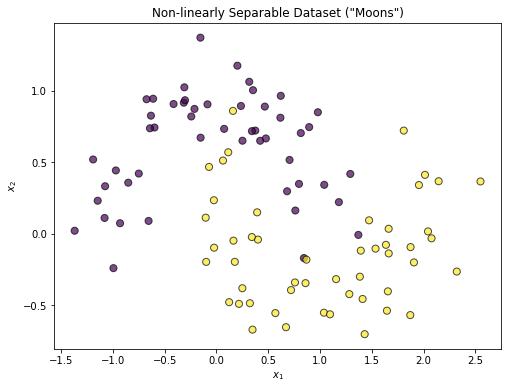

Accuracy: 0.9333333333333333


In [2]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def polynomial(x_i, x_j, c, n):
    return (np.dot(x_i, x_j) + c) ** n

def compute_kernel_matrix(X1, X2, kernel_func, **kwargs):
    n_samples_1, n_samples_2 = X1.shape[0], X2.shape[0]
    K = np.zeros((n_samples_1, n_samples_2))
    for i in range(n_samples_1):
        for j in range(n_samples_2):
            K[i, j] = kernel_func(X1[i], X2[j], **kwargs)
    return K

X, y = make_moons(n_samples=100, noise=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', s=50, alpha=0.7)
plt.title('Non-linearly Separable Dataset ("Moons")')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

c = 1  
n = 3 

K_train = compute_kernel_matrix(X_train, X_train, polynomial, c=c, n=n)
K_test = compute_kernel_matrix(X_test, X_train, polynomial, c=c, n=n)

svm_classifier = SVC(kernel='precomputed')
svm_classifier.fit(K_train, y_train)

y_pred = svm_classifier.predict(K_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


b) Assume we fit an SVM using a polynomial Kernel function and it seems to overfit the data. How would you adjust the tuning parameter `n` of the kernel function?

Reduce the Degree (n) of the Polynomial: A higher-degree polynomial kernel leads to a more complex model, as it tries to fit the training data more closely. This increased complexity can cause the model to learn not only the underlying patterns but also the noise in the training data, which is a classic sign of overfitting. By reducing n, you simplify the model, potentially improving its generalization capabilities by focusing on broader, more significant patterns in the data rather than on minute details.

c) Assume we fit an SVM using a RBF Kernel function and it seems to underfit the data. How would you adjust the tuning parameter `sigma` of the kernel function?

If my SVM model with an RBF kernel is underfitting the data, I should consider increasing the sigma value. Making sigma larger will broaden the RBF kernel's influence, helping my model to capture wider trends and be less sensitive to small variations in the training data. This adjustment aims to make the model more flexible and improve its ability to generalize to new, unseen data. I'll need to experiment or use cross-validation to find the optimal sigma value that minimizes underfitting without leading to overfitting.

d) Tune the parameter of a specific Kernel function, to fit an SVM (using your code above) to the following dataset:

Accuracy: 47.94%


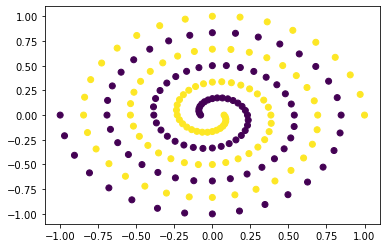

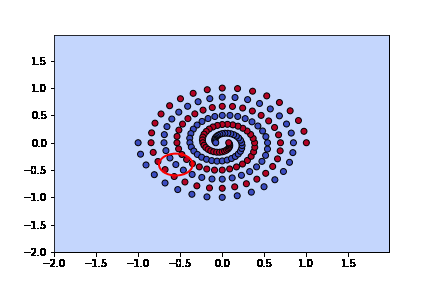

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import io

# Load data
data = np.loadtxt("spiral.data")
x, y = data[:, :2], data[:, 2]

# Initialize variables
alpha_i = np.zeros(len(x))
b = 0
gamma = 1
learning_rate = 0.01  # Set a learning rate

# Define the RBF kernel
def rbf_kernel(x_i, x_j, gamma):
    return np.exp(-gamma * np.linalg.norm(x_i - x_j) ** 2)

# Prediction function using RBF
def predict_rbf(alpha_i, b, x, X, gamma):
    decision_value = sum(alpha_i[j] * rbf_kernel(X[j], x, gamma) for j in range(len(X))) + b
    return decision_value

# Visualization function (simplified for compilation)
def snap_rbf(x, alpha_i, b, X, labels, gamma, error):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    meshData = np.c_[xx.ravel(), yy.ravel()]
    predictions = np.zeros(len(meshData))
    for j in range(len(X)):
        if alpha_i[j] != 0:
            dist_squared = np.sum((meshData - X[j])**2, axis=1)
            predictions += alpha_i[j] * np.exp(-gamma * dist_squared)
    predictions += b
    Z = np.where(predictions <= 0, 0, 1).reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
    ax.scatter(X[:,0], X[:,1], c=labels, cmap=plt.cm.coolwarm, edgecolors='k')
    if error:
        ax.add_patch(plt.Circle((x[0], x[1]), 0.2, color='red', fill=False, lw=2))
    plt.close(fig)

    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    return img

# Training loop with accuracy calculation
images = []
correct_predictions = 0
for epoch in range(len(x)):  # Change 10 to len(x) to iterate through each point
    i = np.random.randint(0, len(x))
    error = False
    xi, yi = x[i], y[i]

    prediction = predict_rbf(alpha_i, b, xi, x, gamma)
    if yi * prediction > 0:  # Correct prediction
        correct_predictions += 1
    else:  # Incorrect prediction
        error = True
        alpha_i[i] += learning_rate * yi
        b += learning_rate * yi
    
    images.append(snap_rbf(xi, alpha_i, b, x, y, gamma, error))

# Calculate and print accuracy
accuracy = correct_predictions / len(x)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Create and save the GIF
gif_path = 'spiral_svm_rbf.gif'
images[0].save(
    gif_path,
    save_all=True,
    append_images=images[1:],
    duration=200,
    loop=0
)

# Display the final plot
plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

display(Image.open(gif_path))
